## Lab Quiz 1

### Problem 1

The goal of this exercise is examining how does the noise influence the ROC curves.

In this problem we receive signals from four different cities: Dubai, Riyahd, Istanbul and New York. Each of the four cities sends a string of $0$'s and $1$'s of length $n$ i.e. 
$$
Y_i \in\{0,1\}^n,
$$
where $Y_1, Y_2, Y_3, Y_4$ denote signals from Dubai, Riyahd, Istanbul, and New York respectively.

Due to the distance from the radio station in Abu Dhabi, where the messages are received, each radio signal $Y_i$ is corrupted by random noise $\epsilon_i\in\mathbb{R}^n$. Thus, instead of the signal $Y_i$, Abu Dhabi radio station receives the corrupted message $X_i = Y_i + \epsilon_i$. You are given that for all $i\in\{1, 2, 3, 4\}$, each of the entries of $\epsilon_i$ is a normal random variable $\mathcal{N}\left(0, \sigma_i^2\right)$ with $(\sigma_1, \sigma_2, \sigma_3, \sigma_4) = (1/10, 1, 3, 100)$. 

Run the following code to generate signals $Y_i$ and the corresponding corrupted messages $X_i$. We shall store the values of $\sigma_i$ in the array called sigmas. That is, sigmas $= [1/10, 1, 3, 100]$. **We will need this later.**

In [106]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000
X = [0., 0., 0., 0.]
Y = [0., 0., 0., 0.]
sigmas = [1/10, 1, 3, 100]

rng = np.random.RandomState(1234)

for i in range(len(sigmas)):
  Y[i] = rng.binomial(1, 1/2, n)
  X[i] =  Y[i] + sigmas[i] * rng.standard_normal(n)


Given the message $X_i$, we want to classify each of its entries as $0$ or $1$. We know that if $Y_i[j]=0$, then $X_i[j]$ follows the density
$$
f_{i,0}(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{x^2}{2\sigma_i^2}\right).
$$
If $Y_i[j]=1$, then $X_i[j]$ follows the density
$$
f_{i,1}(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{(x-1)^2}{2\sigma_i^2}\right).
$$

---

**Task 1 [0.5 point]:** Implement the function log_L which computes the log-likelihood 



$$
\log \mathcal{L}_i(x) = \log\left(\frac{f_{i, 1}(x)}{f_{i,0}(x)}\right).
$$

It should accept two variables:


*   $x$
*   Index $i$,

and return $\log \mathcal{L}_i(x)$.

Recall that the value of $\sigma_i$ can be accessed by calling sigmas[i].

**Hint:** $$\frac{f_{i, 1}(x)}{f_{i,0}(x)} = \exp\left(-\frac{(x-1)^2}{2\sigma_i^2}+\frac{x^2}{2\sigma_i^2}\right)$$

---

In [107]:
#YOUR ANSWER TO TASK 1

def log_L(x, i):
  # YOUR CODE HERE
  var = sigmas[i] ** 2
  return (x ** 2 - (x - 1) ** 2) / 2 * var

---

**Task 2 [1 point]:** Implement the function calculating True Positive Rate of a given predictor. As an input it should take:


*   Y_hat, the predictions given by the predictor
*   Y, the actual labels

The output should be $TPR\left(\hat{Y}\right)$.

---


In [108]:
#YOUR ANSWER TO TASK 2

def tpr(y_hat, y):
  #Step 1: Calculate the number of positives (i.e. the number of 1's in y)
  total_positives = np.sum(y == 1)
  
  #Step 2: Calculate the number of true positives
  true_positives = np.sum(y == 1 & y_hat == 1)

  return true_positives / total_positives


Run the following code to generate the ROC curves for each of the cities.

Text(0.5, 1.0, 'ROC curves')

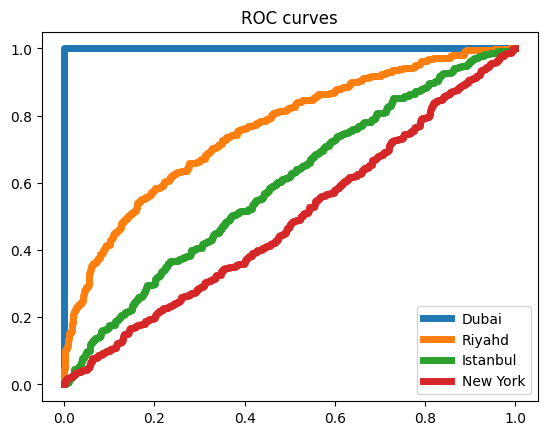

In [109]:
from sklearn.metrics import roc_curve

cities = ['Dubai', 'Riyahd', 'Istanbul', 'New York']
for i in range(4):
    x, y = X[i], Y[i]
    scores = log_L(x, i)
    fpr, tpr, _ = roc_curve(y, scores)
    plt.plot(fpr, tpr, linewidth=5, label=cities[i])
plt.legend(loc = 'lower right')
plt.title('ROC curves')



**Task 3 [0.5 point]:** Provide a brief interpretation of the above ROC curves. How does their behavior depend on the noise level? Why?

**Note:** This is not a coding problem. You can write your answer below.

**Your Answer:** 

It is clear that with the noise level increasing, we can see the curve closer to the diagonal, implying that noise is making it difficult to distinguish between the positive and negative classes. 

The reason is that noise affects the true and false positive rates, making it more challenging to correctly classify samples as noise increases.


### Problem 2

In this part, we will implement the Perceptron algorithm with the data as generated below. 

In [110]:
rng = np.random.default_rng(12345)

n = 100
d = 5
X = rng.standard_normal((n, d))
Y = rng.binomial(1, 1/2, n)
Y = 2 * Y - 1

X = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
Q, _ = np.linalg.qr(rng.standard_normal((d + 1, d + 1)))
X = X @ Q

# Try to think why are this data separable?
# QR factorization makes a rotation transformation on original data including data X and label Y, 
# which introduces dependence within such randomly generated data and labels.
X.shape, Y.shape

((100, 6), (100,))

**Task 5 [1 point]:** Implement the class Perceptron by filling in the missing parts.

In [111]:
# Perceptron update rule
def update(w, X, y, i):
    x_i, y_i = X[i], y[i]
    prediction = np.dot(w, x_i)
    if (prediction >= 0 and y_i < 0) or (prediction < 0 and y_i >= 0):
        w = w + y_i * x_i
    return w

# Empirical risk
def empirical_risk(w, X, Y):
    return np.mean(np.maximum(0, 1 - Y * (np.dot(X, w))))

# Correct predictions
def correct_predictions(w, X, Y):
    return np.mean(Y * (np.dot(X, w)) >= 1)

In [112]:
# Test the implementation
random_seed = 123
max_iter = 1000
eps = 1e-8

# Intialize the model
w = np.zeros(X.shape[1])
losses = []
rng = np.random.default_rng(random_seed)

for j in range(max_iter):
    losses.append(empirical_risk(w, X, Y))
    i = rng.integers(0, len(X))
    w = update(w, X, Y, i)
    if losses[-1] < eps:
        losses.append(empirical_risk(w, X, Y))
        break
        
assert losses[-1] < eps
assert correct_predictions(w, X, Y) == 1

print(f"Model is trained in {j+1} iterations.")
print(f'loss: {losses[-1]}')

Model is trained in 179 iterations.
loss: 0.0


**Task 6 [1 point]:** Compute the margin of the obtained solution, i.e., the closest distance from the separating hyperplane and point from the training data.

In [113]:
# Perceptron update rule
def margin(w, X, Y):
    # YOUR CODE HERE
    margin = np.min(np.dot(X, w) * Y)
    return margin

print(f"Margin of the model is {margin(w, X, Y)}")

Margin of the model is 1.0543733698770246


**Task 7 [1 point]:** Provide the upper bound on the number of errors made by the Perceptron algorithm (recall Theorem 64, mistake bound)
\begin{align*}
    \text{number of mistakes} \leq \frac{ 2 + R^2}{\gamma^2},
\end{align*}
where $R$ is the radius of the smallest ball containing the data and $\gamma$ is the margin of the solution, and compare it with actual number of errors made by the algorithm.

In [114]:
# Perceptron update rule with missclassified flag
def update(w, X, y, i):
    x_i, y_i = X[i], y[i]
    # YOUR CODE HERE
    x_i, y_i = X[i], y[i]
    missclassified = False

    dot_product = np.dot(w, x_i)

    if np.sign(dot_product) != y_i:
        w = w + y_i * x_i  
        missclassified = True 
    
    return w, missclassified

In [115]:
# Test the implementation
random_seed = 123
max_iter = 1000
eps = 1e-8

# Intialize the model
w = np.zeros(X.shape[1])
losses = []
rng = np.random.default_rng(random_seed)
errors = 0

for j in range(max_iter):
    losses.append(empirical_risk(w, X, Y))
    i = rng.integers(0, len(X))
    w, missclassified = update(w, X, Y, i)
    if missclassified:
        errors += 1
    if losses[-1] < eps:
        losses.append(empirical_risk(w, X, Y))
        break
        
assert losses[-1] < eps
assert correct_predictions(w, X, Y) == 1

# YOUR CODE HERE
upper_bound = (2 + (np.max(np.linalg.norm(X, axis=1))) ** 2) / margin(w, X, Y) ** 2


print(f"The Perceptron algorithm made {errors} errors.")
print(f"The upper bound on the number of errors is {upper_bound.astype(int)}.")

The Perceptron algorithm made 4 errors.
The upper bound on the number of errors is 4.


**Bonus [1 point]**: The margin of the above solution is relatively small. Given construction of the data, it is possible to find a solution with a larger margin. Can you find a solution with margin equal to 1? If so, implement it.

**Comment:** Only attempt this if you have completed all the previous tasks. This is a bonus task, so you can skip it if you want.

In [119]:
# YOUR CODE HERE
def adjust_weights_for_margin(w, X, Y):
    current_margin = margin(w, X, Y)
    scaling_factor = 1 / current_margin
    new_w = w * scaling_factor
    new_margin = np.min(np.dot(X, new_w) * Y)
    
    return new_w

new_w = adjust_weights_for_margin(w, X, Y)

print(f"Margin of the model is {margin(new_w, X, Y)}")

Margin of the model is 0.9999999999999999
